In [2]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score as sklearn_f1_score
from sklearn.metrics import precision_score as sklearn_precision_score
from sklearn.metrics import recall_score as sklearn_recall_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.15.0
Eager mode:  True
Hub version:  0.16.1
GPU is NOT AVAILABLE


In [3]:
def load_data(database_filepath):
    # load data from database
    df = pd.read_csv('/content/drive/MyDrive/Disaster Response classifier/augmented_data.csv')
    # prompt: reverse column related to unrelated

    df['related']=df['related'].map(lambda x: 1 if x == 2 else x)
    df['related']=df['related'].map(lambda x: 1 if x == 0 else 0)
    df.rename(columns={"related":"unrelated"}, inplace=True)

    # split the data into features(X) and targets(y, column_names)
    X = df.message
    y = df.iloc[:, 4:40]  # Assuming your categories start from the 5th column
    category_names = y.columns

    return X, y, category_names

X, y, category_names = load_data('DisasterResponse.db')

<ipython-input-3-2080b8e7e73b>:3: DtypeWarning: Columns (2,42,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Disaster Response classifier/augmented_data.csv')


In [ ]:
def load_data(database_filepath):
    # load data from database
    engine = create_engine('sqlite:///{}'.format(database_filepath))
    df = pd.read_sql_table('DisasterResponse', engine)

    # split the data into features(X) and targets(y, column_names)
    X = df.message
    y = df.iloc[:, 4:]  # Assuming your categories start from the 5th column
    category_names = y.columns

    return X, y, category_names

X, y, category_names = load_data('DisasterResponse.db')

In [4]:
def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2 * p * r / (p + r + K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [ ]:
print("Sample of X:")
print(X.head())
# Display the first few rows of y
print("\nSample of y:")
print(y.head())

# Display the category names
print("\nCategory names:")
print(category_names)

Sample of X:
0    Weather update - a cold front from Cuba that c...
1              Is the Hurricane over or is it not over
2                      Looking for someone but no name
3    UN reports Leogane 80-90 destroyed. Only Hospi...
4    says: west side of Haiti, rest of the country ...
Name: message, dtype: object

Sample of y:
   unrelated  request  offer  aid_related  medical_help  medical_products  \
0          0        0      0            0             0                 0   
1          0        0      0            1             0                 0   
2          0        0      0            0             0                 0   
3          0        1      0            1             0                 1   
4          0        0      0            0             0                 0   

   search_and_rescue  security  military  child_alone  ...  aid_centers  \
0                  0         0         0            0  ...            0   
1                  0         0         0            0  .

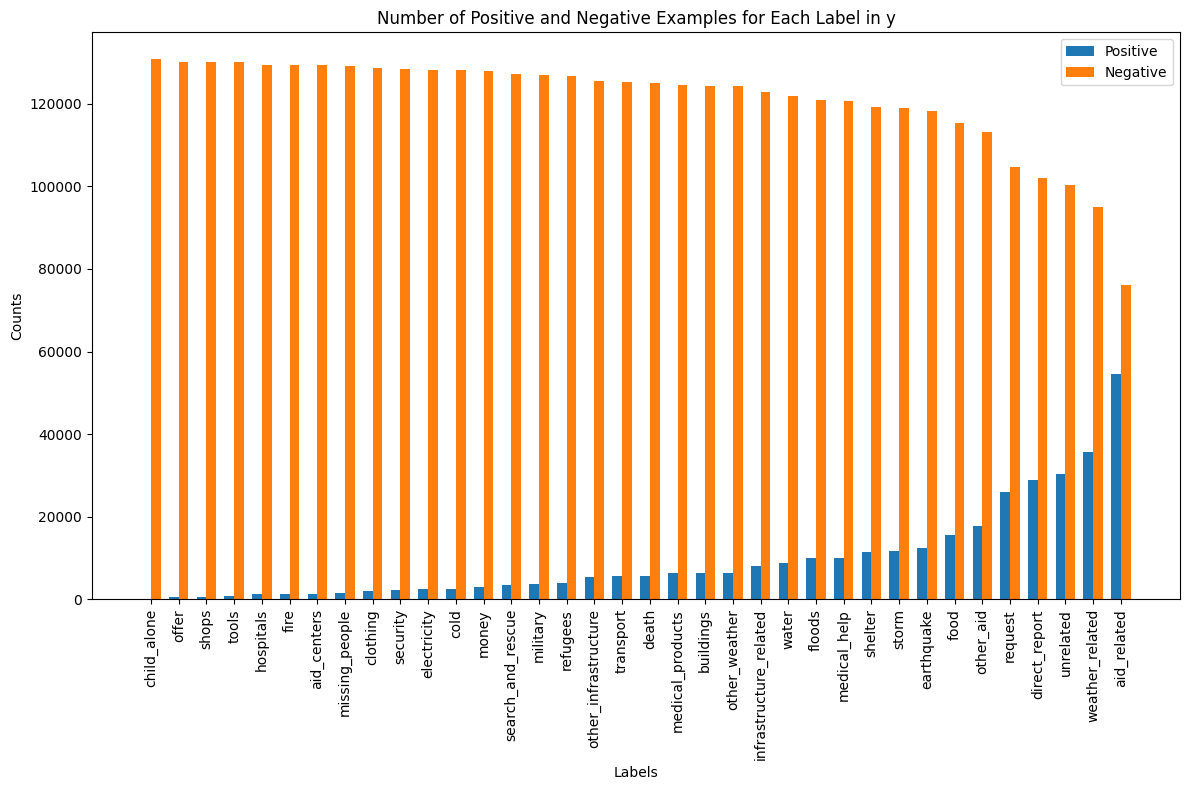

In [5]:
# Calculate positive and negative counts
positive_counts = np.sum(y, axis=0)
negative_counts = y.shape[0] - positive_counts

# Sort by positive counts
sorted_indices = np.argsort(positive_counts)
sorted_positive_counts = positive_counts[sorted_indices]
sorted_negative_counts = negative_counts[sorted_indices]
sorted_category_names = [category_names[i] for i in sorted_indices]

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.35
index = np.arange(len(sorted_category_names))

bar1 = ax.bar(index, sorted_positive_counts, bar_width, label='Positive')
bar2 = ax.bar(index + bar_width, sorted_negative_counts, bar_width, label='Negative')

ax.set_xlabel('Labels')
ax.set_ylabel('Counts')
ax.set_title('Number of Positive and Negative Examples for Each Label in y')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(sorted_category_names, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

In [12]:
# prompt: serperate y into 3 class (common, uncommon, rare) with 12 labels each, according to the number of positive in y labels

import numpy as np
# First, let's sort the labels by the number of positive examples
sorted_indices = np.argsort(positive_counts)
sorted_category_names = [category_names[i] for i in sorted_indices]

# Then, we can divide the labels into three classes based on the number of positive examples
common_labels =sorted_category_names[24:]
uncommon_labels = sorted_category_names[12:24]
rare_labels = sorted_category_names[:12]

# Finally, we can separate y into three classes based on the labels
y_common = y[common_labels]
y_uncommon = y[uncommon_labels]
y_rare = y[rare_labels]

# Print the number of labels in each class
print("Number of common labels:", len(common_labels))
print("Number of uncommon labels:", len(uncommon_labels))
print("Number of rare labels:", len(rare_labels))


Number of common labels: 12
Number of uncommon labels: 12
Number of rare labels: 12


In [ ]:
# prompt: print sample of spilted data

print("Sample of common data:")
print(y_common.head())
print("\nSample of uncommon data:")
print(y_uncommon.head())
print("\nSample of rare data:")
print(y_rare.head())


Sample of common data:
   floods  medical_help  shelter  storm  earthquake  food  other_aid  request  \
0       0             0        0      0           0     0          0        0   
1       0             0        0      1           0     0          1        0   
2       0             0        0      0           0     0          0        0   
3       0             0        0      0           0     0          1        1   
4       0             0        0      0           0     0          0        0   

   direct_report  unrelated  weather_related  aid_related  
0              0          0                0            0  
1              0          0                1            1  
2              0          0                0            0  
3              0          0                0            1  
4              0          0                0            0  

Sample of uncommon data:
   money  search_and_rescue  military  refugees  other_infrastructure  \
0      0                  0    

1) Common lable model

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y_common, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print("Number of rows in X_train:", len(X_train))
print("Number of rows in X_test:", len(X_test))
print("Number of rows in X_val:", len(X_val))
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

Number of rows in X_train: 104596
Number of rows in X_test: 13075
Number of rows in X_val: 13075
(104596,)
(13075,)
(13075,)
(104596, 12)
(13075, 12)
(13075, 12)


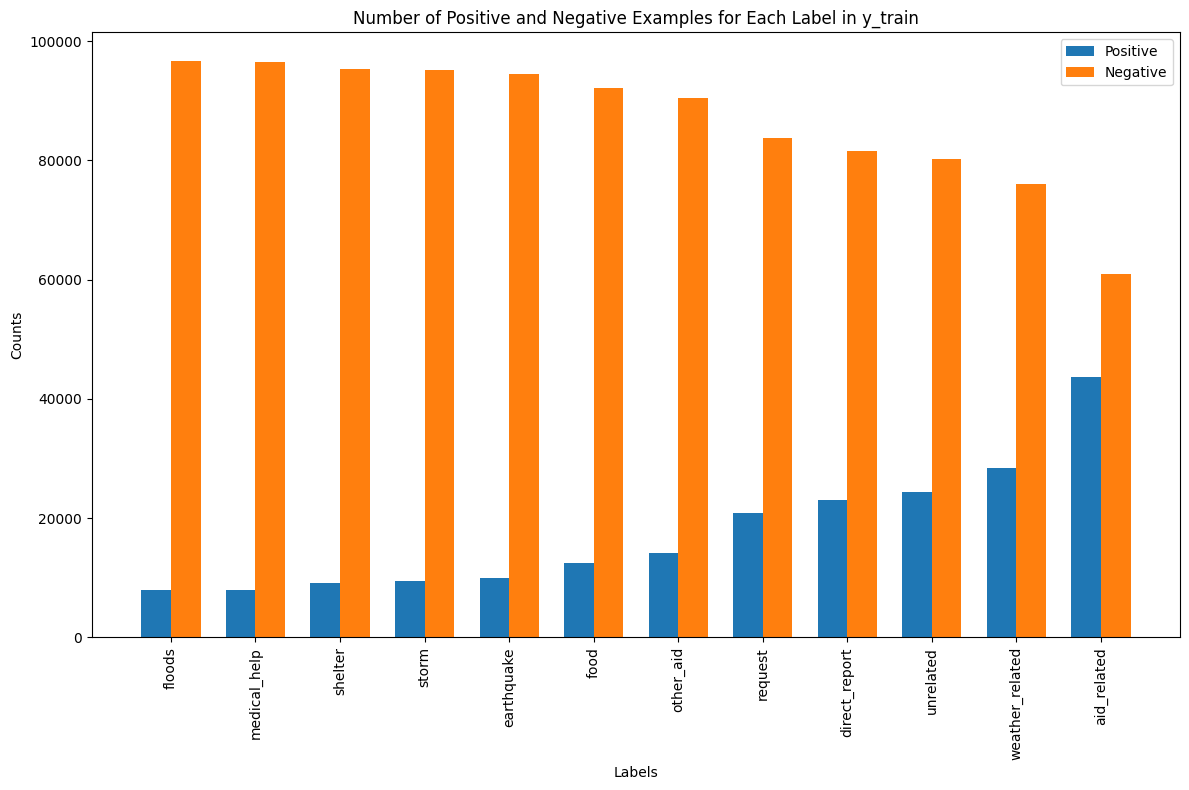

In [ ]:
# Calculate positive and negative counts
positive_counts = np.sum(y_train, axis=0)
negative_counts = y_train.shape[0] - positive_counts

# Sort by positive counts
sorted_indices = np.argsort(positive_counts)
sorted_positive_counts = positive_counts[sorted_indices]
sorted_negative_counts = negative_counts[sorted_indices]
sorted_category_names = y_common.columns

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.35
index = np.arange(len(sorted_category_names))

bar1 = ax.bar(index, sorted_positive_counts, bar_width, label='Positive')
bar2 = ax.bar(index + bar_width, sorted_negative_counts, bar_width, label='Negative')

ax.set_xlabel('Labels')
ax.set_ylabel('Counts')
ax.set_title('Number of Positive and Negative Examples for Each Label in y_train')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(sorted_category_names, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(X_train[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[-0.12796457,  0.05236826,  0.14503987,  0.17085892, -0.36257017,
        -0.05873235, -0.09868292, -0.0439047 , -0.0575024 ,  0.10474018,
         0.04545728,  0.16266379, -0.09521174, -0.14827082, -0.17677948,
         0.16159862, -0.17601472, -0.00928499, -0.03203962, -0.22324657,
        -0.09879953,  0.3597549 ,  0.3616882 , -0.02153605, -0.25867063,
        -0.10648552, -0.13108277, -0.08369046, -0.11364683, -0.07083629,
         0.19265597, -0.06228806,  0.23856501, -0.2082127 , -0.17628753,
        -0.13327034,  0.16472588, -0.07043698,  0.04854732, -0.11912277,
         0.21947172,  0.36629888,  0.07780717,  0.0125143 ,  0.29734546,
         0.07473104, -0.02643751, -0.1949641 ,  0.11151541,  0.29881394],
       [ 0.26743004, -0.01651249, -0.25160336,  0.3399904 ,  0.11821286,
         0.16827433,  0.39503783, -0.24101114, -0.07589889,  0.09115767,
         0.15381552,  0.17100257,  0.17077862,  0.12418135, -0.12464407,
 

In [ ]:
model1 = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Adding dropout for regularization
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Adding another dropout layer
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Adding another dropout layer
    tf.keras.layers.Dense(12, activation='sigmoid')
])
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       f1_score])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 128)               6528      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0

In [ ]:
# prompt: evaluate before training

loss, accuracy, precision, recall, f1 = model1.evaluate(X_test, y_test)
print("Evaluation before training:")
print("- Loss:", loss)
print("- Accuracy:", accuracy)
print("- Precision:", precision)
print("- Recall:", recall)
print("- F1 score:", f1)


NotImplementedError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1153, in f1_score  *
        zero_division=zero_division,
    File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1285, in fbeta_score  *
        _, _, f, _ = precision_recall_fscore_support(
    File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1568, in precision_recall_fscore_support  *
        labels = _check_set_wise_labels(y_true, y_pred, average, labels, pos_label)
    File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 1374, in _check_set_wise_labels  *
        y_type, y_true, y_pred = _check_targets(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py", line 86, in _check_targets  *
        check_consistent_length(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 395, in check_consistent_length  *
        uniques = np.unique(lengths)
    File "/usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py", line 272, in unique  **
        ar = np.asanyarray(ar)

    NotImplementedError: Cannot convert a symbolic tf.Tensor (strided_slice_5:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.


In [9]:
y_train_array = y_train.values

# Calculate class weights for each label separately
class_weights = {}
for i in range(y_train_array.shape[1]):
    class_weights[i] = compute_class_weight('balanced', classes=np.unique(y_train_array[:, i]), y=y_train_array[:, i])
class_weights_mean = {class_label: np.mean(weights_array) for class_label, weights_array in class_weights.items()}

for i in class_weights_mean:
    print(f"Class {i}: {class_weights_mean[i]}")

Class 0: 3.5646858499853202
Class 1: 3.5300239055319995
Class 2: 3.117004909487564
Class 3: 3.050937794707631
Class 4: 2.8823102643460423
Class 5: 2.3897460572714078
Class 6: 2.132396333517775
Class 7: 1.5695593351845623
Class 8: 1.459342904473548
Class 9: 1.3974252464263879
Class 10: 1.261583645186982
Class 11: 1.0278659264523422


In [ ]:
# Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='best_model1.h5', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=10, mode='max', restore_best_weights=True)

]

# Fit the model with class weights
history = model1.fit(
    X_train, y_train,
    epochs=10,  # Set to a larger number and use early stopping
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    batch_size=160,  # You can adjust the batch size
    class_weight=class_weights_mean  # Adding class weights
)

Epoch 1/10
654/654 [==============================] - ETA: 0s - loss: 1.0410 - accuracy: 0.8381 - precision: 0.5444 - recall: 0.2411 - f1_score: 0.1913

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


654/654 [==============================] - 996s 2s/step - loss: 1.0410 - accuracy: 0.8381 - precision: 0.5444 - recall: 0.2411 - f1_score: 0.1913 - val_loss: 0.2807 - val_accuracy: 0.8821 - val_precision: 0.8198 - val_recall: 0.3901 - val_f1_score: 0.2880
Epoch 2/10
654/654 [==============================] - 1023s 2s/step - loss: 0.7540 - accuracy: 0.8818 - precision: 0.7755 - recall: 0.4205 - f1_score: 0.3108 - val_loss: 0.2395 - val_accuracy: 0.8944 - val_precision: 0.8436 - val_recall: 0.4627 - val_f1_score: 0.3253
Epoch 3/10
654/654 [==============================] - 1019s 2s/step - loss: 0.6507 - accuracy: 0.8928 - precision: 0.8111 - recall: 0.4744 - f1_score: 0.3547 - val_loss: 0.2194 - val_accuracy: 0.9001 - val_precision: 0.8595 - val_recall: 0.4910 - val_f1_score: 0.3609
Epoch 4/10
654/654 [==============================] - 1003s 2s/step - loss: 0.5938 - accuracy: 0.9002 - precision: 0.8245 - recall: 0.5182 - f1_score: 0.4087 - val_loss: 0.2057 - val_accuracy: 0.9083 - val_pr

In [ ]:
hub_url = "https://tfhub.dev/google/nnlm-en-dim50/2"

hub_layer = hub.KerasLayer(hub_url, input_shape=[], dtype=tf.string, trainable=True)

model1 = tf.keras.models.load_model('/content/drive/MyDrive/Disaster Response classifier/best_model1.h5', custom_objects={'KerasLayer': hub.KerasLayer, 'f1_score': f1_score})

In [ ]:
loss, accuracy, precision, recall, f1 = model1.evaluate(X_test, y_test)
print("Evaluation on the test set:")
print("- Loss:", loss)
print("- Accuracy:", accuracy)
print("- Precision:", precision)
print("- Recall:", recall)
print("- F1 score:", f1)


409/409 [==============================] - 2s 3ms/step - loss: 0.1850 - accuracy: 0.9327 - precision: 0.8969 - recall: 0.6767 - f1_score: 0.5800
Evaluation on the test set:
- Loss: 0.1849662959575653
- Accuracy: 0.9326577186584473
- Precision: 0.8969160318374634
- Recall: 0.6767128705978394
- F1 score: 0.5800137519836426


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming model is your trained TensorFlow model
# and X_test, y_test are your test data and true labels

# Predict probabilities
y_pred_proba = model1.predict(X_test)

# Apply a threshold of 0.3 to the predicted probabilities
threshold = 0.4
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Evaluate the performance with the new threshold
new_accuracy = accuracy_score(y_test, y_pred_adjusted)
new_precision = precision_score(y_test, y_pred_adjusted, average='weighted')
new_recall = recall_score(y_test, y_pred_adjusted, average='weighted')
new_f1 = f1_score(y_test, y_pred_adjusted, average='weighted')

print(f"Adjusted Precision: {new_precision}")
print(f"Adjusted Recall: {new_recall}")
print(f"Adjusted F1 Score: {new_f1}")


409/409 [==============================] - 1s 2ms/step
Adjusted Precision: 0.8024250250601307
Adjusted Recall: 0.7679635604479028
Adjusted F1 Score: 0.7820476846569191


In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming model is your trained TensorFlow model
# and X_test, y_test are your test data and true labels
# and category_names is a list of category names

# Predict probabilities
y_pred_proba = model1.predict(X_test)

# Apply a threshold of 0.4 to the predicted probabilities
threshold = 0.4
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Compute precision, recall, and F1 score for each label
precision_scores = precision_score(y_test, y_pred_adjusted, average=None)
recall_scores = recall_score(y_test, y_pred_adjusted, average=None)
f1_scores = f1_score(y_test, y_pred_adjusted, average=None)

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Category': sorted_category_names,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
})

# Display the table
print(results_df.to_string(index=False))


409/409 [==============================] - 75s 183ms/step
       Category  Precision   Recall  F1 Score
         floods   0.643002 0.652263  0.647600
   medical_help   0.576172 0.301328  0.395708
        shelter   0.527482 0.503810  0.515375
          storm   0.625106 0.617253  0.621155
     earthquake   0.741826 0.866348  0.799266
           food   0.721629 0.698320  0.709783
      other_aid   0.440714 0.357474  0.394754
        request   0.902828 0.866922  0.884510
  direct_report   0.812283 0.731224  0.769625
      unrelated   0.886800 0.744209  0.809272
weather_related   0.934448 0.960355  0.947225
    aid_related   0.935484 0.948623  0.942008


409/409 [==============================] - 75s 184ms/step


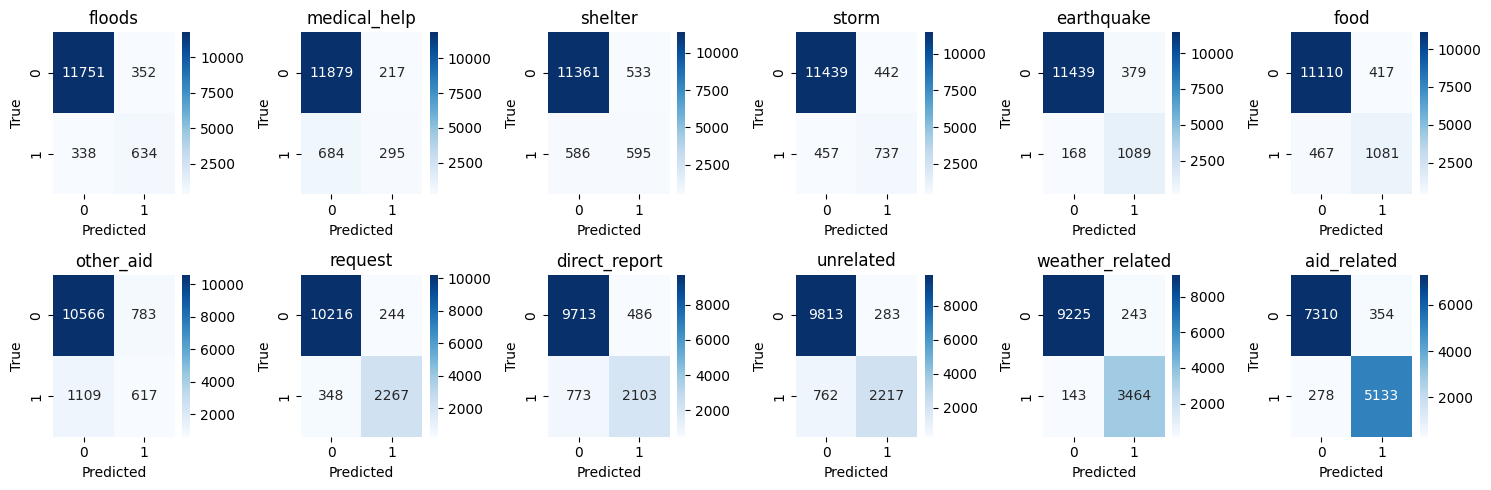

In [ ]:
# prompt: Create a confusion matrix for each label. with model predict threshold of 0.3

import matplotlib.pyplot as plt
# Assuming model is your trained TensorFlow model
# and X_test, y_test are your test data and true labels

# Predict probabilities
y_pred_proba = model1.predict(X_test)

# Apply a threshold of 0.4 to the predicted probabilities
threshold = 0.4
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Create a confusion matrix for each label
confusion_matrices = []
for i in range(y_test.shape[1]):
    cm = confusion_matrix(y_test.iloc[:, i], y_pred_adjusted[:, i])
    confusion_matrices.append(cm)

# Plot the confusion matrices
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15, 5))
for i, (cm, label) in enumerate(zip(confusion_matrices, sorted_category_names)):
    ax = axes[i // 6, i % 6]
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap="Blues")
    ax.set_title(label)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()


In [ ]:
# prompt: Create a confusion matrix for each label. with model predict threshold of 0.3

import matplotlib.pyplot as plt
# Assuming model is your trained TensorFlow model
# and X_test, y_test are your test data and true labels

# Predict probabilities
y_pred_proba = model1.predict(X_test)

# Apply a threshold of 0.4 to the predicted probabilities
threshold = 0.4
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Create a confusion matrix for each label
confusion_matrices = []
for i in range(y_test.shape[1]):
    cm = confusion_matrix(y_test.iloc[:, i], y_pred_adjusted[:, i])
    confusion_matrices.append(cm)

# Plot the confusion matrices
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15, 5))
for i, (cm, label) in enumerate(zip(confusion_matrices, sorted_category_names)):
    ax = axes[i // 6, i % 6]
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap="Blues")
    ax.set_title(label)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y_uncommon, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print("Number of rows in X_train:", len(X_train))
print("Number of rows in X_test:", len(X_test))
print("Number of rows in X_val:", len(X_val))
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

Number of rows in X_train: 104596
Number of rows in X_test: 13075
Number of rows in X_val: 13075
(104596,)
(13075,)
(13075,)
(104596, 12)
(13075, 12)
(13075, 12)


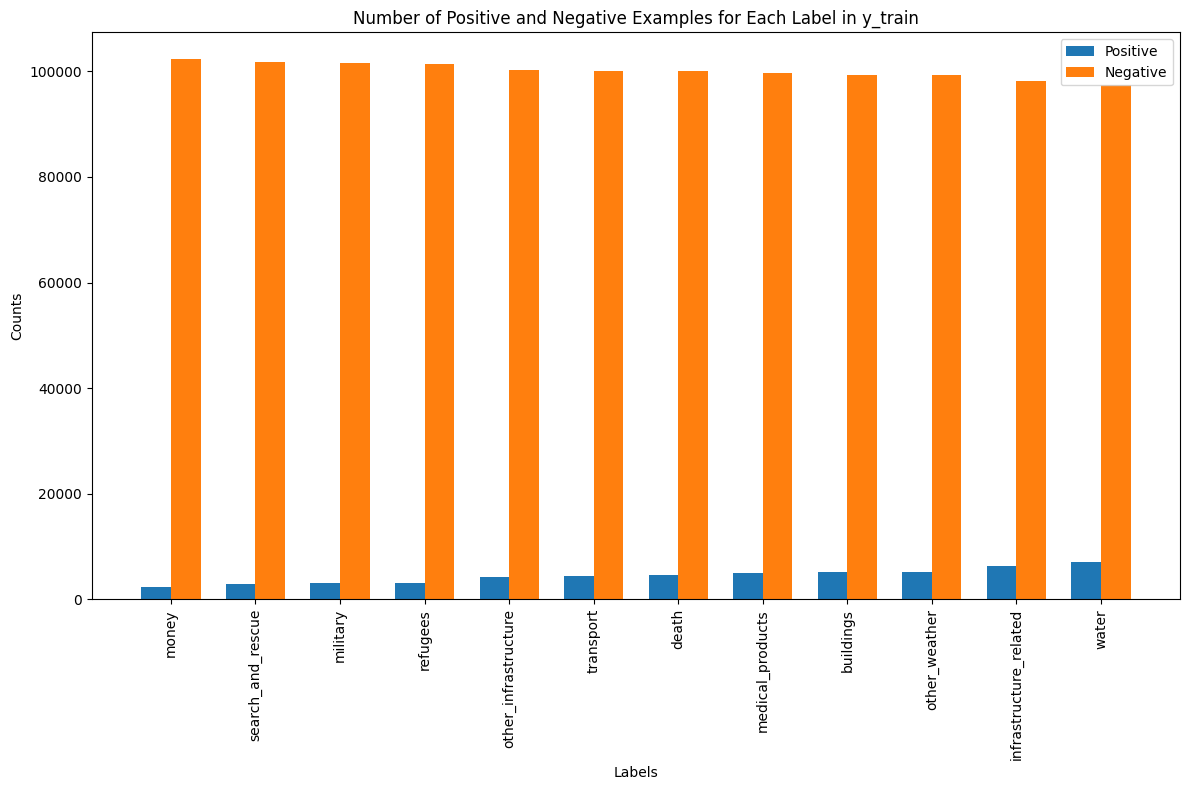

In [ ]:
# Calculate positive and negative counts
positive_counts = np.sum(y_train, axis=0)
negative_counts = y_train.shape[0] - positive_counts

# Sort by positive counts
sorted_indices = np.argsort(positive_counts)
sorted_positive_counts = positive_counts[sorted_indices]
sorted_negative_counts = negative_counts[sorted_indices]
sorted_category_names = y_uncommon.columns

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.35
index = np.arange(len(sorted_category_names))

bar1 = ax.bar(index, sorted_positive_counts, bar_width, label='Positive')
bar2 = ax.bar(index + bar_width, sorted_negative_counts, bar_width, label='Negative')

ax.set_xlabel('Labels')
ax.set_ylabel('Counts')
ax.set_title('Number of Positive and Negative Examples for Each Label in y_train')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(sorted_category_names, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

In [15]:
import numpy as np

# Identify the indices of the rows where y_train is a zero vector
zero_indices = np.where((y_train == 0).all(axis=1))[0]

# Determine the number of zero rows to delete (80% of them)
num_to_delete = int(0.8 * len(zero_indices))

# Randomly select 80% of the zero rows to delete
np.random.seed(42)  # For reproducibility
delete_indices = np.random.choice(zero_indices, size=num_to_delete, replace=False)

# Create a mask that is True for rows to keep
keep_mask = np.ones(len(y_train), dtype=bool)
keep_mask[delete_indices] = False

# Filter out the selected rows from X_train and y_train
x_train_filtered = X_train[keep_mask]
y_train_filtered = y_train[keep_mask]

print(x_train_filtered.shape)
print(y_train_filtered.shape)


(46431,)
(46431, 12)


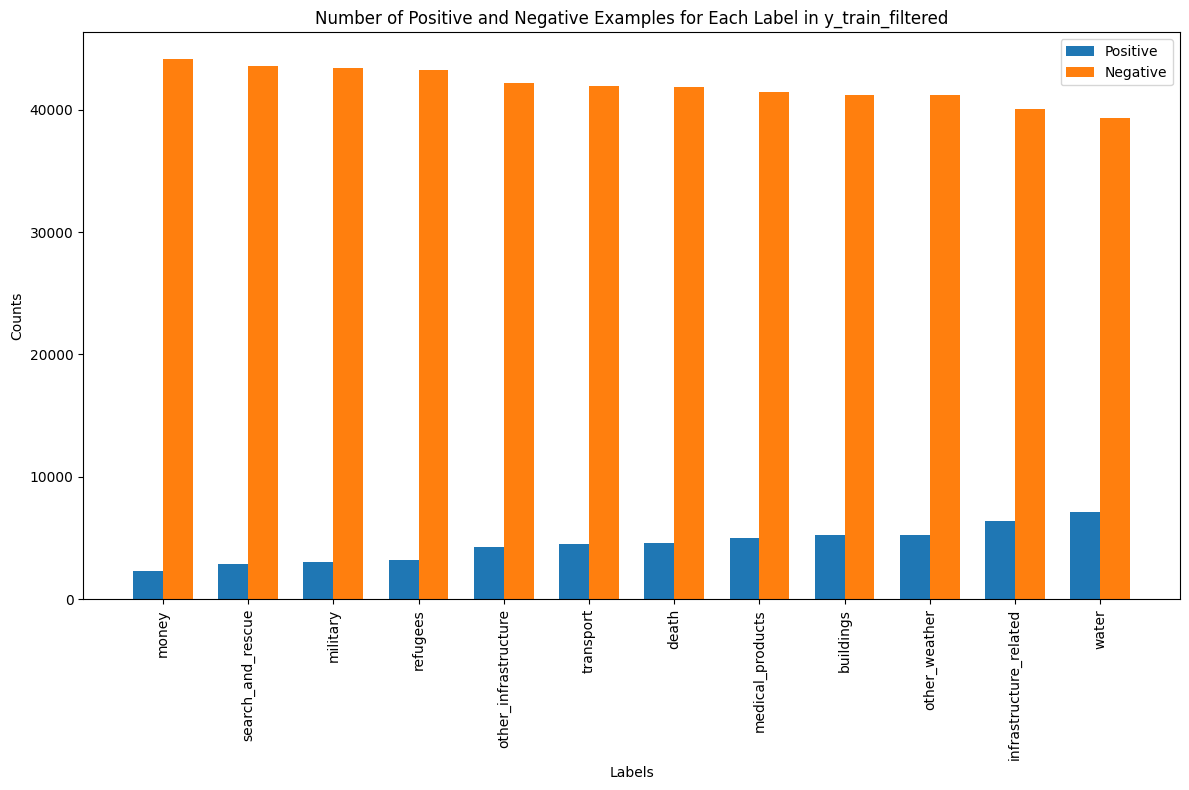

In [16]:
# Calculate positive and negative counts
positive_counts = np.sum(y_train_filtered, axis=0)
negative_counts = y_train_filtered.shape[0] - positive_counts

# Sort by positive counts
sorted_indices = np.argsort(positive_counts)
sorted_positive_counts = positive_counts[sorted_indices]
sorted_negative_counts = negative_counts[sorted_indices]
sorted_category_names = y_uncommon.columns

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.35
index = np.arange(len(sorted_category_names))

bar1 = ax.bar(index, sorted_positive_counts, bar_width, label='Positive')
bar2 = ax.bar(index + bar_width, sorted_negative_counts, bar_width, label='Negative')

ax.set_xlabel('Labels')
ax.set_ylabel('Counts')
ax.set_title('Number of Positive and Negative Examples for Each Label in y_train_filtered')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(sorted_category_names, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

In [17]:
model2 = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Adding dropout for regularization
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Adding another dropout layer
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Adding another dropout layer
    tf.keras.layers.Dense(12, activation='sigmoid')
])
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       f1_score])
model2.summary()

NameError: name 'hub_layer' is not defined

In [19]:
y_train_array = y_train_filtered.values

# Calculate class weights for each label separately
class_weights = {}
for i in range(y_train_array.shape[1]):
    class_weights[i] = compute_class_weight('balanced', classes=np.unique(y_train_array[:, i]), y=y_train_array[:, i])
class_weights_mean = {class_label: np.mean(weights_array) for class_label, weights_array in class_weights.items()}


for i in class_weights_mean:
    print(f"Class {i}: {class_weights_mean[i]}")

Class 0: 5.247208360263403
Class 1: 4.312386962351501
Class 2: 4.098394108955376
Class 3: 3.9129176019836427
Class 4: 2.9849698848149124
Class 5: 2.858030800998539
Class 6: 2.7858343106368926
Class 7: 2.5980662080376393
Class 8: 2.504954118243011
Class 9: 2.49910410460748
Class 10: 2.102576077551463
Class 11: 1.9309157365568415


In [ ]:
# Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='best_model2.h5', save_best_only=True),
]

# Fit the model with class weights
history = model2.fit(
    x_train_filtered, y_train_filtered,
    epochs=12,  # Set to a larger number and use early stopping
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    batch_size=160,  # You can adjust the batch size
    class_weight=class_weights_mean  # Adding class weights
)

Epoch 1/12
291/291 [==============================] - ETA: 0s - loss: 1.2320 - accuracy: 0.8612 - precision: 0.1669 - recall: 0.1095 - f1_score: 0.1012

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


291/291 [==============================] - 425s 1s/step - loss: 1.2320 - accuracy: 0.8612 - precision: 0.1669 - recall: 0.1095 - f1_score: 0.1012 - val_loss: 0.1055 - val_accuracy: 0.9614 - val_precision: 0.7866 - val_recall: 0.1344 - val_f1_score: 0.1229
Epoch 2/12
291/291 [==============================] - 434s 1s/step - loss: 0.7170 - accuracy: 0.9180 - precision: 0.7188 - recall: 0.2477 - f1_score: 0.2995 - val_loss: 0.0865 - val_accuracy: 0.9688 - val_precision: 0.7263 - val_recall: 0.4353 - val_f1_score: 0.4173
Epoch 3/12
291/291 [==============================] - 434s 1s/step - loss: 0.6060 - accuracy: 0.9291 - precision: 0.7820 - recall: 0.3689 - f1_score: 0.4151 - val_loss: 0.0777 - val_accuracy: 0.9713 - val_precision: 0.7571 - val_recall: 0.4843 - val_f1_score: 0.4694
Epoch 4/12
291/291 [==============================] - 439s 2s/step - loss: 0.5467 - accuracy: 0.9356 - precision: 0.8146 - recall: 0.4315 - f1_score: 0.4722 - val_loss: 0.0737 - val_accuracy: 0.9721 - val_preci

In [ ]:
loss, accuracy, precision, recall, f1 = model2.evaluate(X_test, y_test)
print("Evaluation on the test set:")
print("- Loss:", loss)
print("- Accuracy:", accuracy)
print("- Precision:", precision)
print("- Recall:", recall)
print("- F1 score:", f1)

409/409 [==============================] - 87s 212ms/step - loss: 0.0704 - accuracy: 0.9755 - precision: 0.7197 - recall: 0.6713 - f1_score: 0.4453
Evaluation on the test set:
- Loss: 0.0703936442732811
- Accuracy: 0.9754684567451477
- Precision: 0.719710648059845
- Recall: 0.671266496181488
- F1 score: 0.44530823826789856


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming model is your trained TensorFlow model
# and X_test, y_test are your test data and true labels

# Predict probabilities
y_pred_proba = model2.predict(X_test)

# Apply a threshold of 0.3 to the predicted probabilities
threshold = 0.45
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Evaluate the performance with the new threshold
new_accuracy = accuracy_score(y_test, y_pred_adjusted)
new_precision = precision_score(y_test, y_pred_adjusted, average='weighted')
new_recall = recall_score(y_test, y_pred_adjusted, average='weighted')
new_f1 = f1_score(y_test, y_pred_adjusted, average='weighted')

print(f"Adjusted Precision: {new_precision}")
print(f"Adjusted Recall: {new_recall}")
print(f"Adjusted F1 Score: {new_f1}")


409/409 [==============================] - 76s 186ms/step
Adjusted Precision: 0.6821813873418561
Adjusted Recall: 0.7166513339466422
Adjusted F1 Score: 0.6850232402894019


In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming model is your trained TensorFlow model
# and X_test, y_test are your test data and true labels
# and category_names is a list of category names

# Predict probabilities
y_pred_proba = model2.predict(X_test)

# Apply a threshold of 0.4 to the predicted probabilities
threshold = 0.45
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Compute precision, recall, and F1 score for each label
precision_scores = precision_score(y_test, y_pred_adjusted, average=None)
recall_scores = recall_score(y_test, y_pred_adjusted, average=None)
f1_scores = f1_score(y_test, y_pred_adjusted, average=None)

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Category': sorted_category_names,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
})

# Display the table
print(results_df.to_string(index=False))


409/409 [==============================] - 77s 189ms/step
              Category  Precision   Recall  F1 Score
                 money   0.662921 0.825175  0.735202
     search_and_rescue   0.529661 0.344353  0.417362
              military   0.680089 0.878613  0.766709
              refugees   0.732394 0.380488  0.500803
  other_infrastructure   0.640687 0.934489  0.760188
             transport   0.667883 0.359528  0.467433
                 death   0.748549 0.708791  0.728128
      medical_products   0.706845 0.739875  0.722983
             buildings   0.684062 0.763780  0.721726
         other_weather   0.601399 0.565789  0.583051
infrastructure_related   0.675649 0.883812  0.765837
                 water   0.761417 0.915919  0.831552


409/409 [==============================] - 79s 192ms/step


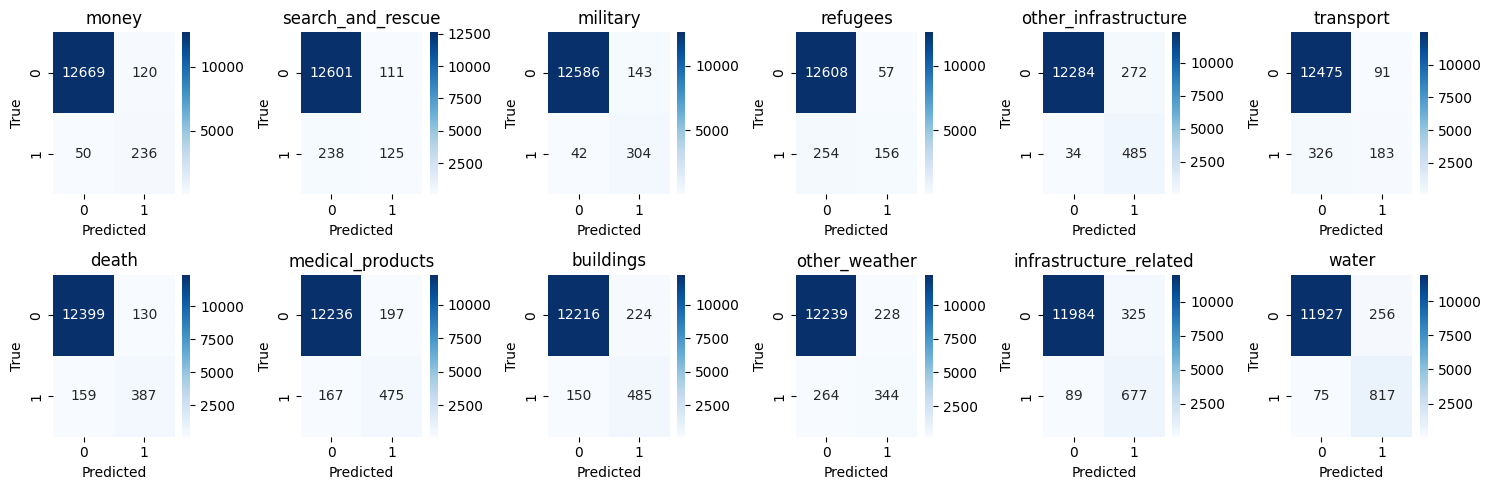

In [ ]:
# prompt: Create a confusion matrix for each label. with model predict threshold of 0.3

import matplotlib.pyplot as plt
# Assuming model is your trained TensorFlow model
# and X_test, y_test are your test data and true labels

# Predict probabilities
y_pred_proba = model2.predict(X_test)

# Apply a threshold of 0.4 to the predicted probabilities
threshold = 0.45
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Create a confusion matrix for each label
confusion_matrices = []
for i in range(y_test.shape[1]):
    cm = confusion_matrix(y_test.iloc[:, i], y_pred_adjusted[:, i])
    confusion_matrices.append(cm)

# Plot the confusion matrices
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15, 5))
for i, (cm, label) in enumerate(zip(confusion_matrices, sorted_category_names)):
    ax = axes[i // 6, i % 6]
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap="Blues")
    ax.set_title(label)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y_rare, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print("Number of rows in X_train:", len(X_train))
print("Number of rows in X_test:", len(X_test))
print("Number of rows in X_val:", len(X_val))
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

Number of rows in X_train: 104596
Number of rows in X_test: 13075
Number of rows in X_val: 13075
(104596,)
(13075,)
(13075,)
(104596, 12)
(13075, 12)
(13075, 12)


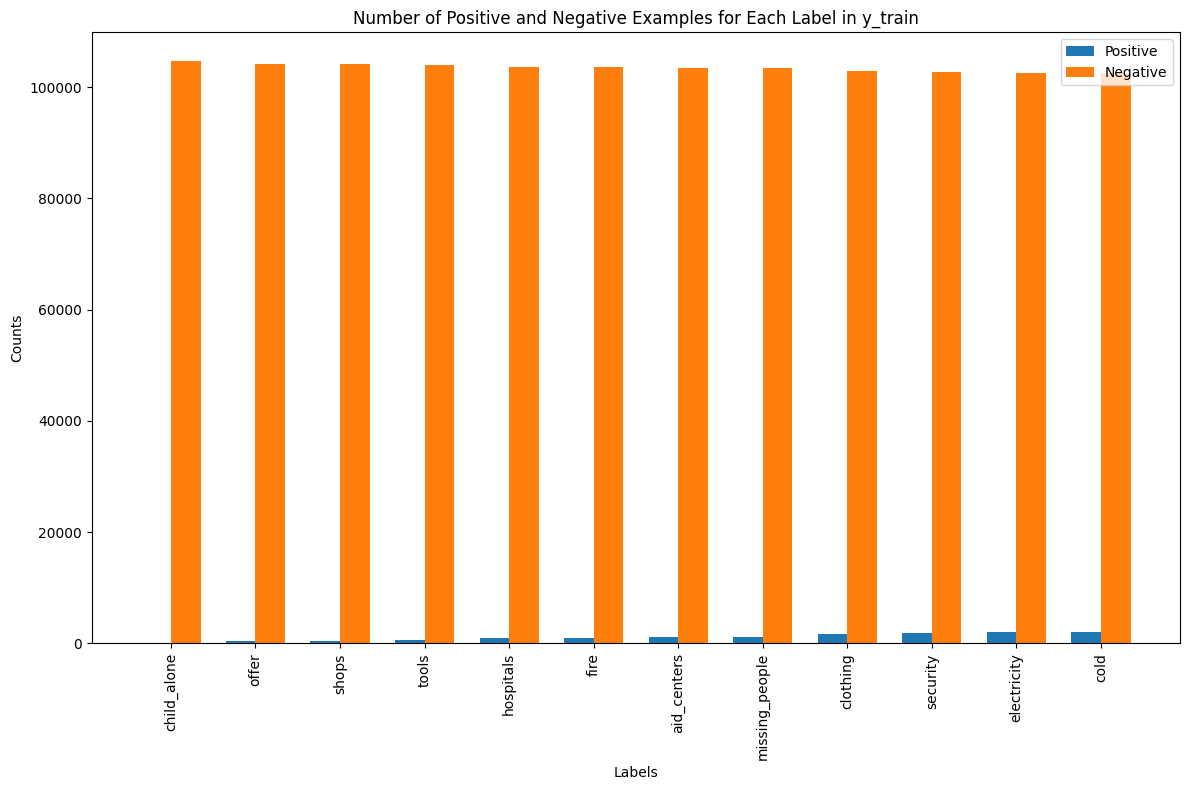

In [ ]:
# Calculate positive and negative counts
positive_counts = np.sum(y_train, axis=0)
negative_counts = y_train.shape[0] - positive_counts

# Sort by positive counts
sorted_indices = np.argsort(positive_counts)
sorted_positive_counts = positive_counts[sorted_indices]
sorted_negative_counts = negative_counts[sorted_indices]
sorted_category_names = y_rare.columns

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.35
index = np.arange(len(sorted_category_names))

bar1 = ax.bar(index, sorted_positive_counts, bar_width, label='Positive')
bar2 = ax.bar(index + bar_width, sorted_negative_counts, bar_width, label='Negative')

ax.set_xlabel('Labels')
ax.set_ylabel('Counts')
ax.set_title('Number of Positive and Negative Examples for Each Label in y_train')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(sorted_category_names, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

In [21]:
import numpy as np

# Identify the indices of the rows where y_train is a zero vector
zero_indices = np.where((y_train == 0).all(axis=1))[0]

# Determine the number of zero rows to delete (80% of them)
num_to_delete = int(0.9 * len(zero_indices))

# Randomly select 80% of the zero rows to delete
np.random.seed(42)  # For reproducibility
delete_indices = np.random.choice(zero_indices, size=num_to_delete, replace=False)

# Create a mask that is True for rows to keep
keep_mask = np.ones(len(y_train), dtype=bool)
keep_mask[delete_indices] = False

# Filter out the selected rows from X_train and y_train
x_train_filtered = X_train[keep_mask]
y_train_filtered = y_train[keep_mask]

y_train_filtered = y_train_filtered.drop('child_alone', axis=1)
y_val = y_val.drop('child_alone', axis=1)
y_test = y_test.drop('child_alone', axis=1)

print(x_train_filtered.shape)
print(y_train_filtered.shape)
print(y_val.shape)
print(y_test.shape)


(20416,)
(20416, 11)
(13075, 11)
(13075, 11)


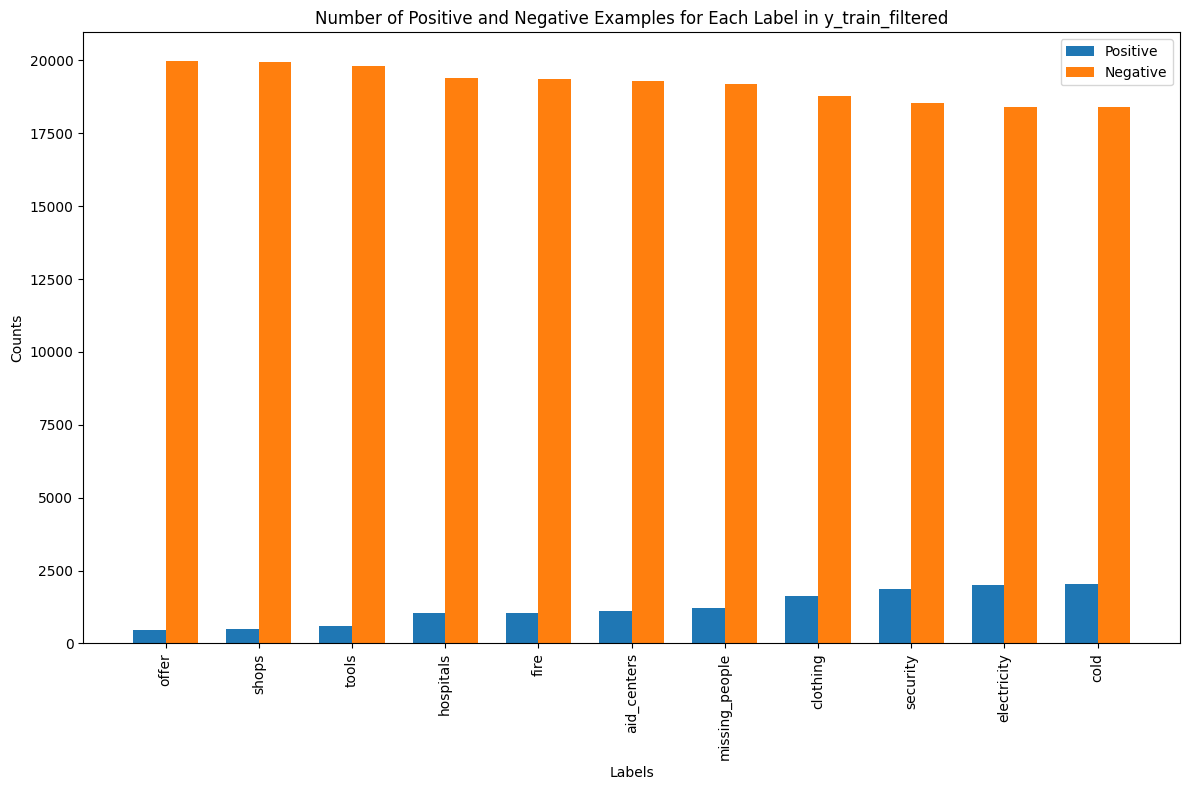

In [ ]:
# Calculate positive and negative counts
positive_counts = np.sum(y_train_filtered, axis=0)
negative_counts = y_train_filtered.shape[0] - positive_counts

# Sort by positive counts
sorted_indices = np.argsort(positive_counts)
sorted_positive_counts = positive_counts[sorted_indices]
sorted_negative_counts = negative_counts[sorted_indices]
sorted_category_names = y_train_filtered.columns

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.35
index = np.arange(len(sorted_category_names))

bar1 = ax.bar(index, sorted_positive_counts, bar_width, label='Positive')
bar2 = ax.bar(index + bar_width, sorted_negative_counts, bar_width, label='Negative')

ax.set_xlabel('Labels')
ax.set_ylabel('Counts')
ax.set_title('Number of Positive and Negative Examples for Each Label in y_train_filtered')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(sorted_category_names, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
model3 = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Adding dropout for regularization
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Adding another dropout layer
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Adding another dropout layer
    tf.keras.layers.Dense(11, activation='sigmoid')
])
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       f1_score])
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_4 (Dense)             (None, 128)               6528      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)               

In [22]:
y_train_array = y_train_filtered.values

# Calculate class weights for each label separately
class_weights = {}
for i in range(y_train_array.shape[1]):
    class_weights[i] = compute_class_weight('balanced', classes=np.unique(y_train_array[:, i]), y=y_train_array[:, i])
class_weights_mean = {class_label: np.mean(weights_array) for class_label, weights_array in class_weights.items()}

for i in class_weights_mean:
    print(f"Class {i}: {class_weights_mean[i]}")

Class 0: 11.623105072144094
Class 1: 10.889352594970571
Class 2: 8.922961546066173
Class 3: 5.124507064418249
Class 4: 5.20427222405598
Class 5: 4.8297785360982655
Class 6: 4.4494952841951365
Class 7: 3.384031508828084
Class 8: 2.98312266762971
Class 9: 2.8329389137726895
Class 10: 2.796791895677025


In [ ]:
# Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='best_model3.h5', save_best_only=True),
]

# Fit the model with class weights
history = model3.fit(
    x_train_filtered, y_train_filtered,
    epochs=20,  # Set to a larger number and use early stopping
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    batch_size=160,  # You can adjust the batch size
    class_weight=class_weights_mean  # Adding class weights
)

Epoch 1/20
128/128 [==============================] - ETA: 0s - loss: 2.6915 - accuracy: 0.8584 - precision: 0.0597 - recall: 0.0920 - f1_score: 0.0419

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


128/128 [==============================] - 212s 2s/step - loss: 2.6915 - accuracy: 0.8584 - precision: 0.0597 - recall: 0.0920 - f1_score: 0.0419 - val_loss: 0.0688 - val_accuracy: 0.9882 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/20
128/128 [==============================] - 205s 2s/step - loss: 1.4500 - accuracy: 0.9373 - precision: 0.0703 - recall: 0.0036 - f1_score: 0.0056 - val_loss: 0.0587 - val_accuracy: 0.9882 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/20
128/128 [==============================] - 217s 2s/step - loss: 1.1957 - accuracy: 0.9396 - precision: 0.0494 - recall: 2.9658e-04 - f1_score: 4.2365e-04 - val_loss: 0.0518 - val_accuracy: 0.9882 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/20
128/128 [==============================] - 209s 2s/step - loss: 1.0568 - accuracy: 0.9399 - precision: 0.4054 - recall: 0.0022 - f1_score: 0.0034 - val_los

In [ ]:
loss, accuracy, precision, recall, f1 = model3.evaluate(X_test, y_test)
print("Evaluation on the test set:")
print("- Loss:", loss)
print("- Accuracy:", accuracy)
print("- Precision:", precision)
print("- Recall:", recall)
print("- F1 score:", f1)

409/409 [==============================] - 96s 231ms/step - loss: 0.0310 - accuracy: 0.9915 - precision: 0.6270 - recall: 0.6258 - f1_score: 0.1765
Evaluation on the test set:
- Loss: 0.030990438535809517
- Accuracy: 0.991482675075531
- Precision: 0.6269841194152832
- Recall: 0.6258379220962524
- F1 score: 0.17647705972194672


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming model is your trained TensorFlow model
# and X_test, y_test are your test data and true labels

# Predict probabilities
y_pred_proba = model3.predict(X_test)

# Apply a threshold of 0.5 to the predicted probabilities
threshold = 0.50
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Evaluate the performance with the new threshold
new_accuracy = accuracy_score(y_test, y_pred_adjusted)
new_precision = precision_score(y_test, y_pred_adjusted, average='weighted')
new_recall = recall_score(y_test, y_pred_adjusted, average='weighted')
new_f1 = f1_score(y_test, y_pred_adjusted, average='weighted')

print(f"Adjusted Precision: {new_precision}")
print(f"Adjusted Recall: {new_recall}")
print(f"Adjusted F1 Score: {new_f1}")


409/409 [==============================] - 79s 194ms/step
Adjusted Precision: 0.6289617553474304
Adjusted Recall: 0.6093845216331505
Adjusted F1 Score: 0.6063655446067026


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming model is your trained TensorFlow model
# and X_test, y_test are your test data and true labels
# and category_names is a list of category names

# Predict probabilities
y_pred_proba = model3.predict(X_test)

# Apply a threshold of 0.4 to the predicted probabilities
threshold = 0.5
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Compute precision, recall, and F1 score for each label
precision_scores = precision_score(y_test, y_pred_adjusted, average=None)
recall_scores = recall_score(y_test, y_pred_adjusted, average=None)
f1_scores = f1_score(y_test, y_pred_adjusted, average=None)

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Category': sorted_category_names,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
})

# Display the table
print(results_df.to_string(index=False))


409/409 [==============================] - 85s 206ms/step
      Category  Precision   Recall  F1 Score
         offer   0.358779 0.854545  0.505376
         shops   0.000000 0.000000  0.000000
         tools   0.000000 0.000000  0.000000
     hospitals   0.606452 0.676259  0.639456
          fire   0.748031 0.669014  0.706320
   aid_centers   0.658537 0.446281  0.532020
missing_people   0.652695 0.767606  0.705502
      clothing   0.702381 0.842857  0.766234
      security   0.666667 0.520930  0.584856
   electricity   0.561350 0.750000  0.642105
          cold   0.678261 0.621514  0.648649


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


409/409 [==============================] - 80s 196ms/step


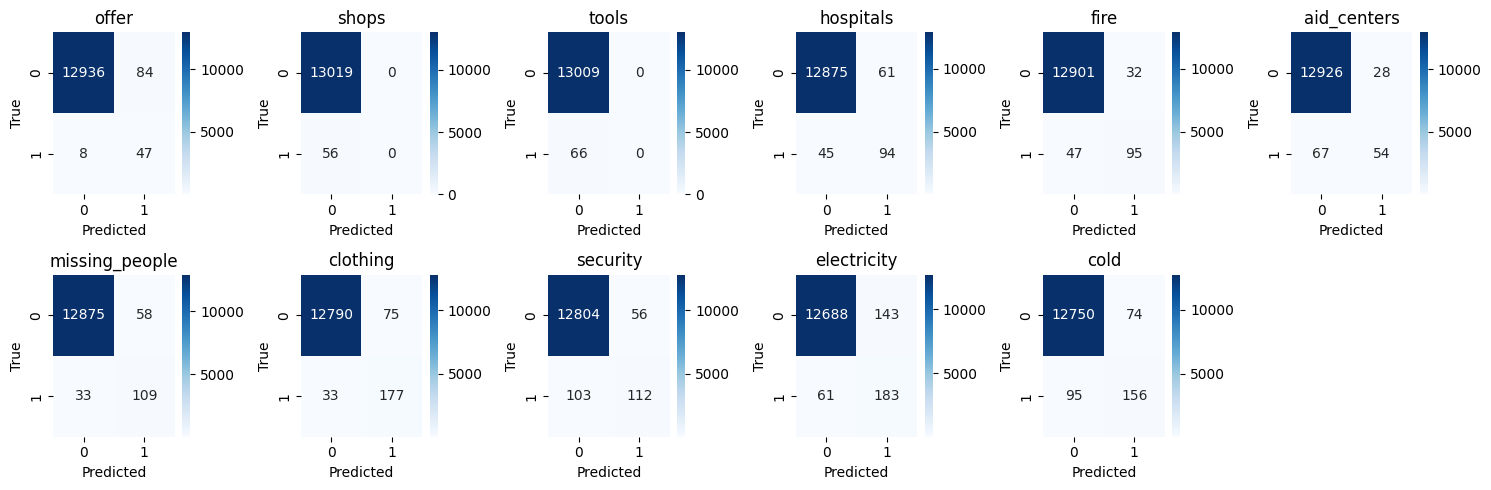

In [ ]:
# Predict probabilities
y_pred_proba = model3.predict(X_test)

# Apply a threshold of 0.5 to the predicted probabilities
threshold = 0.5
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Create a confusion matrix for each label
confusion_matrices = []
for i in range(y_test.shape[1]):
    cm = confusion_matrix(y_test.iloc[:, i], y_pred_adjusted[:, i])
    confusion_matrices.append(cm)

# Plot the confusion matrices
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15, 5))

# Flatten axes for easy iteration
axes = axes.flatten()

for i, (cm, label) in enumerate(zip(confusion_matrices, sorted_category_names)):
    sns.heatmap(cm, annot=True, fmt="d", ax=axes[i], cmap="Blues")
    axes[i].set_title(label)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
